# Signal echoing

Echoing signal `n` steps is an example of synchronized many-to-many task.

In [19]:
from sequential_tasks import EchoData
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm

# By taking away these seeds, we see that even performance here is very stochastic.

# torch.manual_seed(1)
# np.random.seed(3)

batch_size = 5
echo_step = 7
series_length = 20_000
BPTT_T = 100

train_size = -1
test_size = -1
total_values_in_one_chunck = -1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

feature_dim = 1 #since we have a scalar series
h_units = 20

In [20]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_data():
    global train_size, test_size, total_values_in_one_chunck
    train_data = EchoData(
        echo_step=echo_step,
        batch_size=batch_size,
        series_length=series_length,
        truncated_length=BPTT_T
    )
    total_values_in_one_chunck = batch_size * BPTT_T
    train_size = len(train_data)

    test_data = EchoData(
        echo_step=echo_step,
        batch_size=batch_size,
        series_length=series_length,
        truncated_length=BPTT_T,
    )
    test_data.generate_new_series()
    test_data.prepare_batches()
    test_size = len(test_data)

    return train_data, test_data

In [21]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, output_size):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_cell = torch.nn.RNNCell(
            input_size=input_size, 
            hidden_size=rnn_hidden_size, 
            nonlinearity='relu',
            # batch_first = True?
        )
        self.linear = torch.nn.Linear( # This is the decoder
            in_features=rnn_hidden_size,
            out_features=output_size
        )

    def forward(self, x, hidden):
        batch_size, seq_len, _ = x.size()
        if hidden is None:
            hidden = torch.zeros(batch_size, self.rnn_hidden_size).to(x.device)
            
        hidden_states_list = []
        for t in range(seq_len):
            hidden = self.rnn_cell(x[:, t, :], hidden)
            if self.training:
                hidden.retain_grad() # This .grad attribute will be filled during .backward()
                
            hidden_states_list.append(hidden)

        # Stack to look like the old output (batch, seq, hidden)
        # Note: We stack them, but we will use the LIST for gradient inspection
        # because the list holds the original graph nodes.
        all_hidden = torch.stack(hidden_states_list, dim=1)
        out = self.linear(all_hidden)
        return out, hidden, all_hidden, hidden_states_list

In [22]:
def train():
    model.train()
    
    # New epoch --> fresh hidden state
    hidden = None   
    correct = 0
    for batch_idx in range(train_size):
        data, target = train_data[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        if hidden is not None: hidden.detach_()
        logits, hidden, _, _ = model(data, hidden)

        # RNN has a bijection between 
        # print(data.shape, target.shape)

        loss = criterion(logits, target) # It doesn't do anything really special
        # It just has a 1-1 mapping between data and target, all at once.
        # And then it later on does a topological sort, rooted at loss.
        loss.backward() # Calculates all gradients involved (anything that has autograd=True)
        # And adds the grad dL/dw_i
        optimizer.step() # This just steps all of those things, but carefully (i.e. following
        # a stepping algorithm, like AdamW)

        
        pred = (torch.sigmoid(logits) > 0.5)
        correct += (pred == target.byte()).int().sum().item()/total_values_in_one_chunck
        
    return correct, loss.item()

def test():
    model.eval()   
    correct = 0
    # New epoch --> fresh hidden state
    hidden = None
    with torch.no_grad():
        for batch_idx in range(test_size):
            data, target = test_data[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
            logits, hidden, _, _ = model(data, hidden)
            
            pred = (torch.sigmoid(logits) > 0.5)
            correct += (pred == target.byte()).int().sum().item()/total_values_in_one_chunck

    return correct

In [23]:
from joblib import Parallel, delayed
import os

def run_trial(seed, gpu_id):
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    set_seed(seed)

    print(f"Running seed {seed} on GPU {gpu_id}")
    return train_model(seed)

# What do I want to be returned from this...?

# How Gradients Decay Over Time

In [24]:
model = SimpleRNN(
    input_size=1,
    rnn_hidden_size=h_units,
    output_size=feature_dim
).to(device)
        
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.95, 0.95))

In [25]:
from tqdm import tqdm

n_epochs = 2

for epoch in range(1, n_epochs+1):
    print("hello")
    correct, loss = modified_train()
    print(correct, loss)

#test    
correct = test()
test_accuracy = float(correct) * 100 / test_size
print(f'Test accuracy: {test_accuracy:.1f}%')

hello


NameError: name 'modified_train' is not defined

In [ ]:
train_data, test_data = generate_data()

In [ ]:
len(train_data)

200

In [ ]:
train_size

-1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This visualizes how gradients decay over time

def modified_train():
    print("Hello")
    model.train()

    # New epoch --> fresh hidden state
    hidden = None   
    iterations = min(10000000, train_size)

    total_loss = 0
    total_acc = 0

    for batch_idx in (range(iterations)):
        data, target = train_data[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
        
        optimizer.zero_grad()
        if hidden is not None: hidden.detach_()
        logits, hidden, hidden_stack, hidden_list = model(data, hidden)

        loss = criterion(logits, target) # loss for this batch only
        loss.backward()
        optimizer.step()
        
        pred = (torch.sigmoid(logits) > 0.5)
        correct = (pred == target.byte()).int().sum().item()/total_values_in_one_chunck # acc for this batch only
        with torch.no_grad():
            total_loss += loss.detach().cpu().item()
            total_acc += correct
        
        breakpoint()


    avg_acc = float(total_acc)*100/iterations
    avg_loss = total_loss/iterations
    # (f'Train Epoch: {epoch}/{n_epochs}, loss: {avg_loss:.3f}, accuracy {avg_acc:.1f}%')
    return avg_acc, avg_loss

# Updating One Loss At A Time
Need to change prev_grad_arr, because grads are zeroed each time

In [ ]:
for name, p in model.named_parameters():
    print(name, p.shape)

rnn_cell.weight_ih torch.Size([20, 1])
rnn_cell.weight_hh torch.Size([20, 20])
rnn_cell.bias_ih torch.Size([20])
rnn_cell.bias_hh torch.Size([20])
linear.weight torch.Size([1, 20])
linear.bias torch.Size([1])


In [26]:
feature_dim = 1 #since we have a scalar series
h_units = 20

model = SimpleRNN(
    input_size=1,
    rnn_hidden_size=h_units,
    output_size=feature_dim
).to(device)
        
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.95, 0.95))
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [27]:
train_data, test_data = generate_data()

In [61]:
hidden = None
data, target = train_data[0]
data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)

seq_len = target.shape[1]

i = 10

optimizer.zero_grad()
if hidden is not None: hidden.detach_()
logits, hidden, hidden_stack, hidden_list = model(data, hidden)

loss = criterion(logits[:, i:i+1, :], target[:, i:i+1,:]) * torch.tensor(1/seq_len)
loss.backward(retain_graph = False)

model_dict = {}
for name, p in model.named_parameters():
    print(name, p.shape)
    print(name, " grad ", p.grad)
    print(name, " param ", p)
    model_dict[name] = p # These are the same p in our model

rnn_cell.weight_ih torch.Size([20, 1])
rnn_cell.weight_ih  grad  tensor([[ 1.5087e-04],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 2.5946e-04],
        [-2.3880e-04],
        [-7.9043e-06],
        [-5.3908e-05],
        [ 0.0000e+00],
        [ 4.6072e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 4.6194e-05],
        [ 0.0000e+00],
        [-3.3215e-04],
        [ 8.9873e-05],
        [-4.9140e-05],
        [ 0.0000e+00],
        [ 0.0000e+00]])
rnn_cell.weight_ih  param  Parameter containing:
tensor([[ 0.1033],
        [-0.2007],
        [-0.0140],
        [-0.1527],
        [-0.1528],
        [ 0.1074],
        [ 0.0475],
        [ 0.1693],
        [ 0.0624],
        [-0.0509],
        [ 0.1257],
        [-0.1577],
        [-0.1527],
        [ 0.0216],
        [-0.0759],
        [ 0.0518],
        [ 0.1166],
        [-0.0072],
        [-0.1407],
        [ 0.1631]], requires_grad=True)
rnn_cell.weight_hh torch

# A Working, Tried, And Tested Gradient Decomposition

In [62]:
hidden = None
data, target = train_data[0]
data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)

seq_len = target.shape[1]

i = 10

optimizer.zero_grad()
if hidden is not None: hidden.detach_()
logits, hidden, hidden_stack, hidden_list = model(data, hidden)

loss = criterion(logits[:, i:i+1, :], target[:, i:i+1,:]) * torch.tensor(1/seq_len)
loss.backward(retain_graph = False)

model_dict = {}
for name, p in model.named_parameters():
    print(name, p.shape)
    print(name, " grad ", p.grad)
    print(name, " param ", p)
    model_dict[name] = p # These are the same p in our model
    p.grad = None

dEi = []

with torch.no_grad():
    for j in range(seq_len):
        dEi_dhj = hidden_list[j].grad.clone()
        dEi.append(dEi_dhj)
    print("dEi", dEi[0].shape)
# rnn_cell.weight_ih torch.Size([20, 1])
# rnn_cell.weight_hh torch.Size([20, 20])
# rnn_cell.bias_ih torch.Size([20])
# rnn_cell.bias_hh torch.Size([20])
# linear.weight torch.Size([1, 20])
# linear.bias torch.Size([1])
# dEi torch.Size([5, 20])
# data[:,j,:]:  torch.Size([5, 1])
# h_j_1:  None
# data[:,j,:]:  torch.Size([5, 1])
# h_j_1:  torch.Size([5, 20])
for j in range(seq_len):
    h_prev = -1 # h_{j-1}
    if j == 0:
        h_prev = torch.zeros_like(hidden_list[0]).to(device)
    else:
        h_prev = hidden_list[j-1].detach().clone()

    igates = torch.mm(data[:,j,:].clone(), model_dict["rnn_cell.weight_ih"].t()) + model_dict["rnn_cell.bias_ih"] # These are the same p in our model
    hgates = torch.mm(h_prev, model_dict["rnn_cell.weight_hh"].t()) + model_dict["rnn_cell.bias_hh"] # And when we call activation.backward, it
    print(igates.shape, hgates.shape) # But 
    activation = torch.relu(igates + hgates)

    # Wait, I can just compute a vector jacobian product, because dEt_dhk is a vector. And dhk+/dtheta is the Jacobian.
    print(f"Activation {j}: ", activation.shape)

    activation.backward(dEi[j])

for name, p in model.named_parameters():
    print(name, p.shape)
    print(name, " grad ", p.grad)
    print(name, " param ", p)

        # Interesting, batch_size

        # Calculating dhk+/dtheta
        # if j == 0 or j == 1:
        #     print("data[:,j,:]: ", data[:, j, :].shape)
        #     print("h_j_1: ", None if h_j_1 is None else h_j_1.shape)

        # a_j = model_dict["rnn_cell.weight_ih"] * data[:, j, :]
        # + model_dict["rnn_cell.weight_hh"] * h_j_1 
        # + model_dict["rnn_cell.bias_ih"]
        # + model_dict["rnn_cell.bias_hh"]
        # hj = torch.nn.ReLU(a_j)
        # # Maybe this is assigning the gradient?
        # v = torch.ones_like(hj)
        # hj.backward(v)


# loss_arr = []
# for i in range(seq_len):
#     optimizer.zero_grad()
#     if hidden is not None: hidden.detach_()
#     logits, hidden, hidden_stack, hidden_list = model(data, hidden)

#     loss_arr.append(criterion(logits[:, i:i+1, :], target[:,i:i+1,:]) * torch.tensor(1/seq_len)) # This isn't the 5 step training loop, and will yield problems if I do backward, step all inside the loop
#     loss_arr[-1].backward(retain_graph=False) # Don't need retain_graph=True here
#     # I suspect AdamW to do much better than SGD here
#     dEi = []
#     if batch_idx == batch_of_interest:       
#         with torch.no_grad():
#             for j in range(seq_len):
#                 dEi_dhj = hidden_list[j].grad.clone() # Need to do this, because hidden_states holds the sum_{i<=t} dEi_dhk
#                 dEi.append(dEi_dhj)
#             if i == 0:
#                 plt.figure(figsize=(15, 10))
#                 cmap = cm.viridis
#             norm_list = [torch.norm(dEi_dhj, p=2, dim=-1).mean(0).detach().cpu() for dEi_dhj in dEi]
#             plt.scatter(range(seq_len), 
#                         [np.log(x) for x in norm_list], # some of the norms will literally be 0, for instance if j > i, then dEi_dhj is 0
#                         color=cmap(i/(seq_len-1)), 
#                         label=f"{i} : {loss_arr[-1].detach().cpu().item():.3f}")
#             model_dict = {}
#             for name, p in model.named_parameters():
#                 model_dict[name] = p
# # rnn_cell.weight_ih torch.Size([20, 1])
# # rnn_cell.weight_hh torch.Size([20, 20])
# # rnn_cell.bias_ih torch.Size([20])
# # rnn_cell.bias_hh torch.Size([20])
# # linear.weight torch.Size([1, 20])
# # linear.bias torch.Size([1])
#             for j in range(seq_len):
#                 h_j_1 = -1 # h_{j-1}
#                 if j == 0:
#                     h_j_1 = None
#                 else:
#                     h_j_1 = hidden_list[j-1].detach()

#                 # Calculating dhk+/dtheta
#                 a_j = model_dict["rnn_cell.weight_ih"] * data[:, j, :]
#                 + model_dict["rnn_cell.weight_hh"] * h_j_1 
#                 + model_dict["rnn_cell.bias_ih"]
#                 + model_dict["rnn_cell.bias_hh"]
#                 hj = torch.nn.ReLU(a_j)
#                 # Maybe this is assigning the gradient?
#                 v = torch.ones_like(hj)
#                 hj.backward(v)

#     optimizer.step()
# if batch_idx == batch_of_interest:
#     plt.xlabel("Which Hidden State")
#     plt.ylabel("Norm of Gradient, averaged over batch")
#     plt.legend()
#     plt.show()

rnn_cell.weight_ih torch.Size([20, 1])
rnn_cell.weight_ih  grad  tensor([[ 9.7953e-06],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-1.9242e-04],
        [ 1.0272e-04],
        [-2.5800e-05],
        [ 9.8676e-05],
        [ 0.0000e+00],
        [-1.0005e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-3.7505e-05],
        [ 0.0000e+00],
        [ 1.7988e-04],
        [-8.2646e-05],
        [ 1.1536e-06],
        [ 0.0000e+00],
        [ 0.0000e+00]])
rnn_cell.weight_ih  param  Parameter containing:
tensor([[ 0.1033],
        [-0.2007],
        [-0.0140],
        [-0.1527],
        [-0.1528],
        [ 0.1074],
        [ 0.0475],
        [ 0.1693],
        [ 0.0624],
        [-0.0509],
        [ 0.1257],
        [-0.1577],
        [-0.1527],
        [ 0.0216],
        [-0.0759],
        [ 0.0518],
        [ 0.1166],
        [-0.0072],
        [-0.1407],
        [ 0.1631]], requires_grad=True)
rnn_cell.weight_hh torch

0
1


/var/folders/32/bzhrljpn11q6c0sjbvcy_mnc0000gq/T/ipykernel_17585/3002855349.py:53: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  [np.log(x) for x in norm_list], # some of the norms will literally be 0, for instance if j > i, then dEi_dhj is 0
/var/folders/32/bzhrljpn11q6c0sjbvcy_mnc0000gq/T/ipykernel_17585/3002855349.py:53: RuntimeWarning: divide by zero encountered in log
  [np.log(x) for x in norm_list], # some of the norms will literally be 0, for instance if j > i, then dEi_dhj is 0


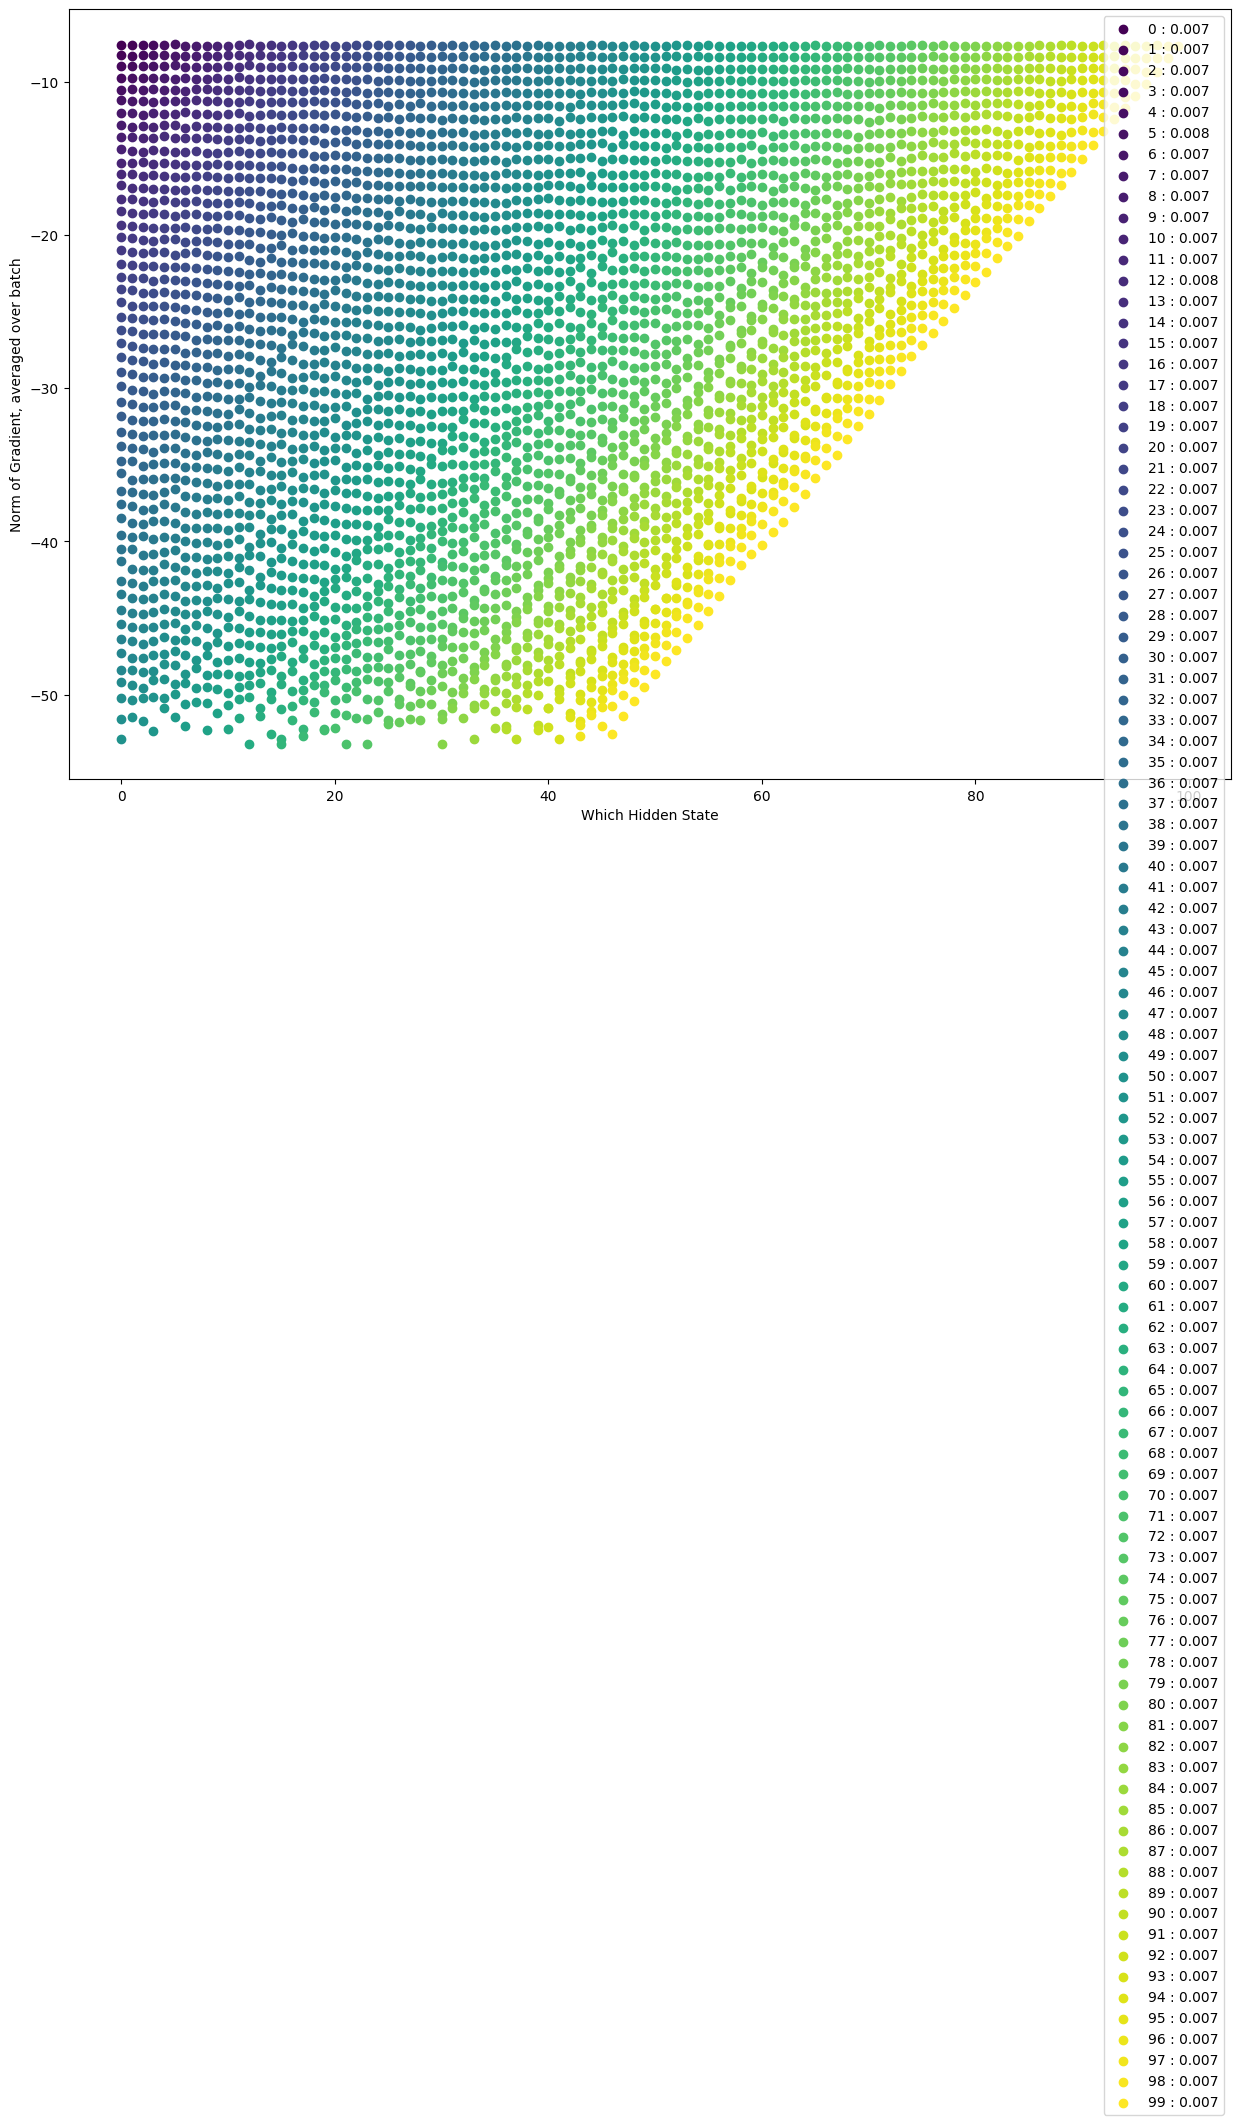

2
3
4
5
6
7
8
9
Train Epoch: 1/1, loss: 0.503, accuracy 64.0%


(6.398, tensor(0.5027))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# This visualizes how gradients decay over time (Adam can be used here)

model.train()

# New epoch --> fresh hidden state
hidden = None   
correct = 0
iterations = min(10000000, train_size)
for batch_idx in (range(iterations)):
    print(batch_idx)
    data, target = train_data[batch_idx]
    data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).float().to(device)
    
    seq_len = target.shape[1]
    batch_of_interest = 1

    loss_arr = []
    for i in range(seq_len):
        optimizer.zero_grad()
        if hidden is not None: hidden.detach_()
        logits, hidden, hidden_stack, hidden_list = model(data, hidden)

        loss_arr.append(criterion(logits[:, i:i+1, :], target[:,i:i+1,:]) * torch.tensor(1/seq_len)) # This isn't the 5 step training loop, and will yield problems if I do backward, step all inside the loop
        loss_arr[-1].backward(retain_graph=False) # Don't need retain_graph=True here
        # I suspect AdamW to do much better than SGD here
        dEi = []
        if batch_idx == batch_of_interest:       
            with torch.no_grad():
                for j in range(seq_len):
                    dEi_dhj = hidden_list[j].grad.clone() # Need to do this, because hidden_states holds the sum_{i<=t} dEi_dhk
                    dEi.append(dEi_dhj)
                if i == 0:
                    plt.figure(figsize=(15, 10))
                    cmap = cm.viridis
                norm_list = [torch.norm(dEi_dhj, p=2, dim=-1).mean(0).detach().cpu() for dEi_dhj in dEi]
                plt.scatter(range(seq_len), 
                            [np.log(x) for x in norm_list], # some of the norms will literally be 0, for instance if j > i, then dEi_dhj is 0
                            color=cmap(i/(seq_len-1)), 
                            label=f"{i} : {loss_arr[-1].detach().cpu().item():.3f}")
                model_dict = {}
                for name, p in model.named_parameters():
                    model_dict[name] = p
# rnn_cell.weight_ih torch.Size([20, 1])
# rnn_cell.weight_hh torch.Size([20, 20])
# rnn_cell.bias_ih torch.Size([20])
# rnn_cell.bias_hh torch.Size([20])
# linear.weight torch.Size([1, 20])
# linear.bias torch.Size([1])
                for j in range(seq_len):
                    h_j_1 = -1 # h_{j-1}
                    if j == 0:
                        h_j_1 = None
                    else:
                        h_j_1 = hidden_list[j-1].detach()

                    # Calculating dhk+/dtheta
                    a_j = model_dict["rnn_cell.weight_ih"] * data[:, j, :]
                    + model_dict["rnn_cell.weight_hh"] * h_j_1 
                    + model_dict["rnn_cell.bias_ih"]
                    + model_dict["rnn_cell.bias_hh"]
                    hj = torch.nn.ReLU(a_j)
                    # Maybe this is assigning the gradient?
                    v = torch.ones_like(hj)
                    hj.backward(v)

        optimizer.step()
    if batch_idx == batch_of_interest:
        plt.xlabel("Which Hidden State")
        plt.ylabel("Norm of Gradient, averaged over batch")
        plt.legend()
        plt.show()
        # training time i=0 first, then stepping, then training time i=1 next, then stepping
    
    with torch.no_grad():
        loss = sum(loss_arr)
    
    pred = (torch.sigmoid(logits) > 0.5)
    correct += (pred == target.byte()).int().sum().item()/total_values_in_one_chunck
    
train_accuracy = float(correct)*100/ iterations
print((f'Train Epoch: {epoch}/{n_epochs}, loss: {loss:.3f}, accuracy {train_accuracy:.1f}%'))
correct, loss

Design an experiment that measures how quickly AdamW learns for different length echos (or, whats the frequency of success, when we backpropagate one loss at a time versus backpropagating everything at once). Keeping into consideration BPTT_length.

This is a good preliminary thing to do. Also, this is all predicated on the idea that AdamW is a SNR update thing, which is something I'll take for granted.

Preliminary looks make it seem as a larger hidden dimension makes it easier for the backpropagate all at once method to converge.
Whereas backpropagate one loss at a time doesn't need a large hidden dimension. When you backpropagate one step at a time, each parameter focuses on their one job. This is kind of like a coordinate descent thing. If you backpropagate everything at once, there will never be a time where the dominant gradient is from something a bunch of time steps ahead (nah, this argument is flawed).

I don't really see a clear reason why backpropagating one step at a time versus all at once would make a big difference. But I can see a time when updating all T^2 combinations of dEi/dhj * dhj+/dtheta would make a difference. Because your modularizing the network, and actually focusing on the credit assignment. That would be a good experiment.